In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from nbeats_pytorch.model import NBeatsNet
from sklearn.metrics import mean_squared_error

In [2]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install scipy
#!pip install statsmodels
#!pip install scikit-learn
#!pip install torch
#!pip install nbeats_pytorch

In [8]:
NAO_df = pd.read_csv("../../1_DatasetCharacteristics/norm.daily.nao.cdas.z500.19500101_current.csv")

In [4]:
NAO_df

year  month  day  nao_index_cdas
0      1950      1    1        0.365000
1      1950      1    2        0.096000
2      1950      1    3       -0.416000
3      1950      1    4       -0.616000
4      1950      1    5       -0.261000
...     ...    ...  ...             ...
27159  2024      5   11        0.688005
27160  2024      5   12        0.517683
27161  2024      5   13        0.520576
27162  2024      5   14        0.357431
27163  2024      5   15       -0.142666

[27164 rows x 4 columns]

In [5]:
# convert to datetime format and set as index
NAO_df['date'] = pd.to_datetime(NAO_df[['year', 'month', 'day']])
# Drop the individual year, month, day columns if needed
NAO_df.drop(columns=['year', 'month', 'day'], inplace=True)
NAO_df.set_index('date', inplace=True)

print(NAO_df)

            nao_index_cdas
date                      
1950-01-01        0.365000
1950-01-02        0.096000
1950-01-03       -0.416000
1950-01-04       -0.616000
1950-01-05       -0.261000
...                    ...
2024-05-11        0.688005
2024-05-12        0.517683
2024-05-13        0.520576
2024-05-14        0.357431
2024-05-15       -0.142666

[27164 rows x 1 columns]


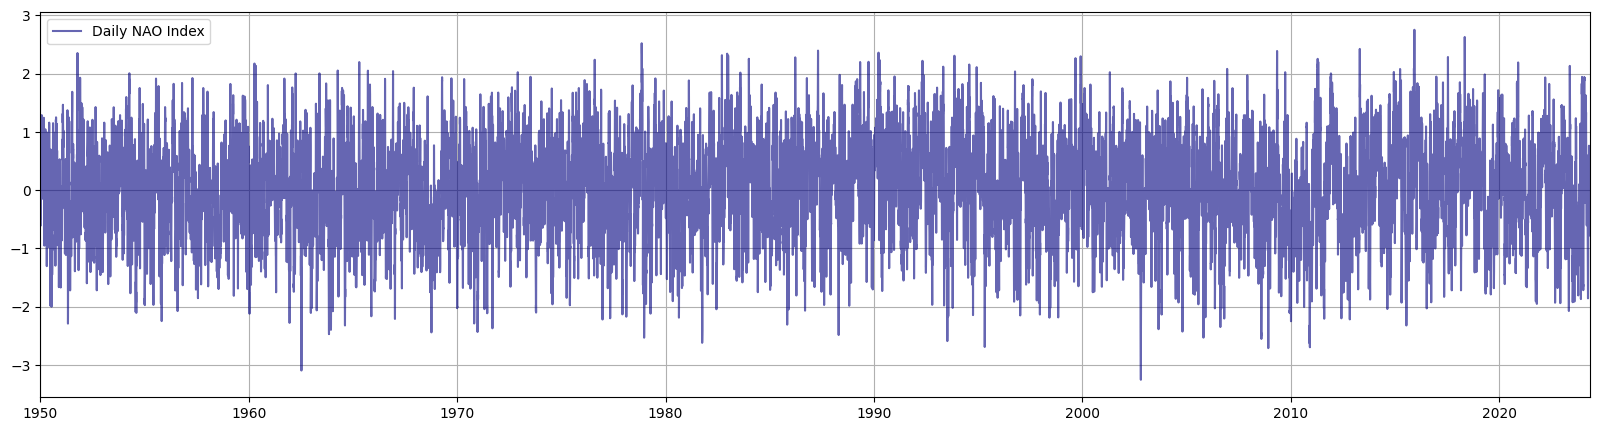

In [6]:
#simple visulization of the time series
plt.figure(figsize=[20,5])
plt.plot(NAO_df["nao_index_cdas"],alpha=0.6,label="Daily NAO Index",color="navy")
plt.xlim(-7305,19855)
plt.legend()
plt.grid()

## Stochastic Analysis

In [7]:
#check for missing values:
print("Found " + str(pd.isna(NAO_df["nao_index_cdas"].values).sum()) + " missing values in the dataframe.")

Found 2 missing values in the dataframe.


In [8]:
# Find missing values
np.where(pd.isna(NAO_df["nao_index_cdas"])==True)
print(NAO_df.index[[20752, 20844]])
# interpolate missing values
NAO_df["nao_index_cdas"] = NAO_df["nao_index_cdas"].interpolate(method='linear')

DatetimeIndex(['2006-10-26', '2007-01-26'], dtype='datetime64[ns]', name='date', freq=None)


In [9]:
# check again:
print("Found " + str(pd.isna(NAO_df["nao_index_cdas"].values).sum()) + " missing values in the dataframe.")

Found 0 missing values in the dataframe.


In [10]:
st.describe(NAO_df["nao_index_cdas"].values)

DescribeResult(nobs=27164, minmax=(np.float64(-3.253999948501587), np.float64(2.75131893157959)), mean=np.float64(0.024639346337295344), variance=np.float64(0.6627130825704842), skewness=np.float64(-0.164699755200186), kurtosis=np.float64(-0.18316863592215515))

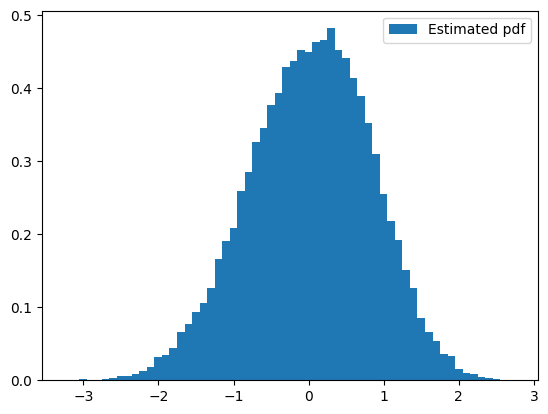

In [11]:
plt.hist(NAO_df["nao_index_cdas"],bins=60,density=True,label="Estimated pdf")
plt.legend()
plt.show()

In [12]:
st.describe(NAO_df["nao_index_cdas"]["1950":"1980"])

DescribeResult(nobs=11323, minmax=(np.float64(-3.0950000286102295), np.float64(2.5199999809265137)), mean=np.float64(-0.025210809759961154), variance=np.float64(0.6255226680459232), skewness=np.float64(-0.14895231648517193), kurtosis=np.float64(-0.22425763828848044))

In [13]:
st.describe(NAO_df["nao_index_cdas"]["1980":"2009"])

DescribeResult(nobs=10958, minmax=(np.float64(-3.253999948501587), np.float64(2.3940000534057617)), mean=np.float64(0.068958160738376), variance=np.float64(0.6694916989023104), skewness=np.float64(-0.23589712583723524), kurtosis=np.float64(-0.06498461759629981))

In [14]:
st.describe(NAO_df["nao_index_cdas"]["2010"])

DescribeResult(nobs=365, minmax=(np.float64(-2.6961724758148193), np.float64(1.1569489240646362)), mean=np.float64(-0.5796321871186517), variance=np.float64(0.4429502599437567), skewness=np.float64(-0.3311268750472349), kurtosis=np.float64(0.36953782653447664))

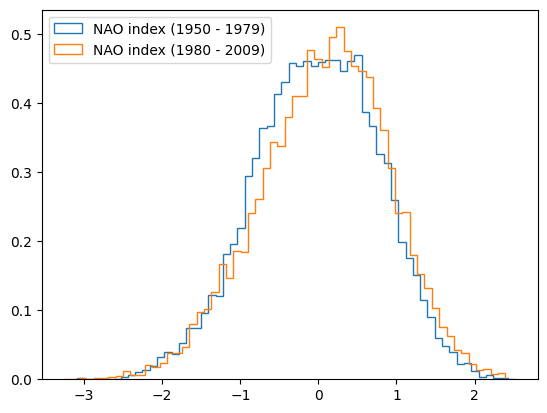

In [15]:
plt.hist(NAO_df["nao_index_cdas"]["1950":"1979"],bins=60,histtype="step",density=True,label="NAO index (1950 - 1979)")
plt.hist(NAO_df["nao_index_cdas"]["1980":"2009"],bins=60,histtype="step",density=True,label="NAO index (1980 - 2009)")
#plt.hist(NAO_df["nao_index_cdas"]["2010":],bins=60,histtype="step",density=True,label="NAO index (2010 - 2024(May))")
plt.legend()
plt.show()

(0.0, 500.0)

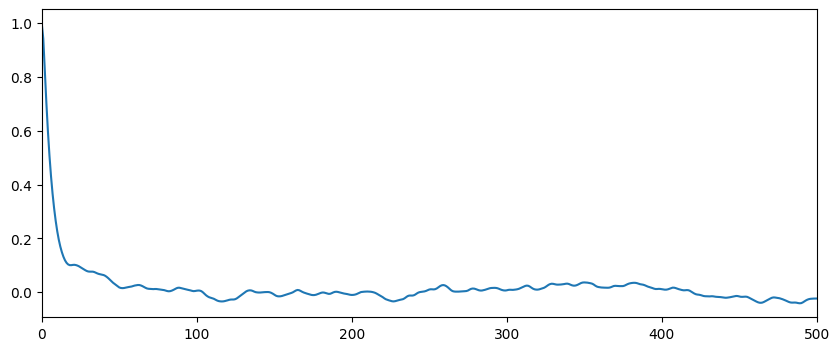

In [16]:
# autocorrelation function:
autocorr_NAO = sm.tsa.acf(NAO_df["nao_index_cdas"], nlags=500)
plt.figure(figsize=[10,4])
plt.plot(autocorr_NAO)
plt.xlim(0,500)

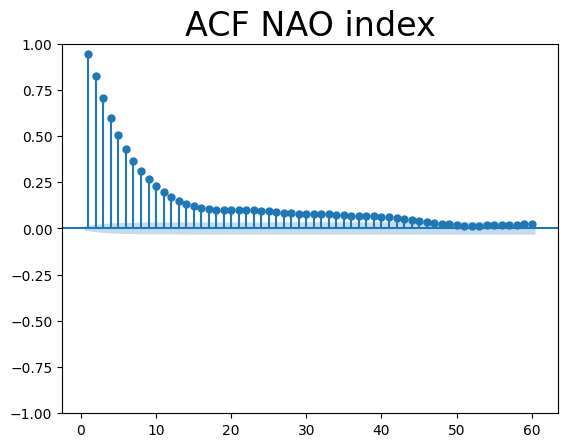

In [17]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(NAO_df["nao_index_cdas"], lags = 60, zero = False)
plt.title("ACF NAO index", size = 24)
plt.show()

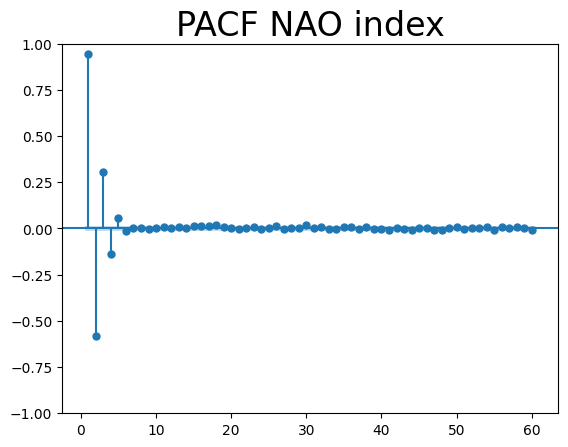

In [18]:
sgt.plot_pacf(NAO_df["nao_index_cdas"], lags = 60, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

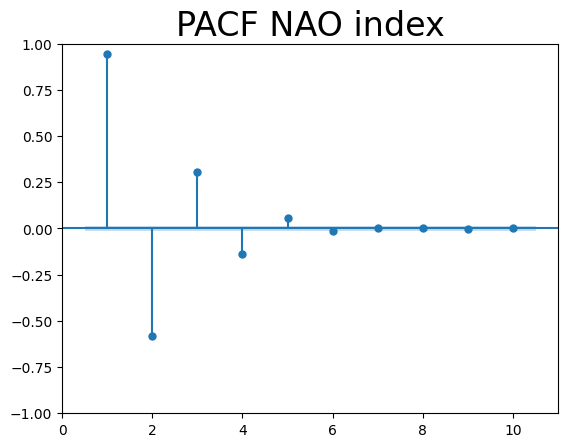

In [19]:
sgt.plot_pacf(NAO_df["nao_index_cdas"], lags = 10, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

In [20]:
import statsmodels.tsa.stattools as sts
sts.adfuller(NAO_df["nao_index_cdas"])

(np.float64(-26.938412553014487),
 0.0,
 18,
 27145,
 {'1%': np.float64(-3.4305909253450193),
  '5%': np.float64(-2.8616464820788914),
  '10%': np.float64(-2.5668266772326875)},
 np.float64(-8311.6214417484))

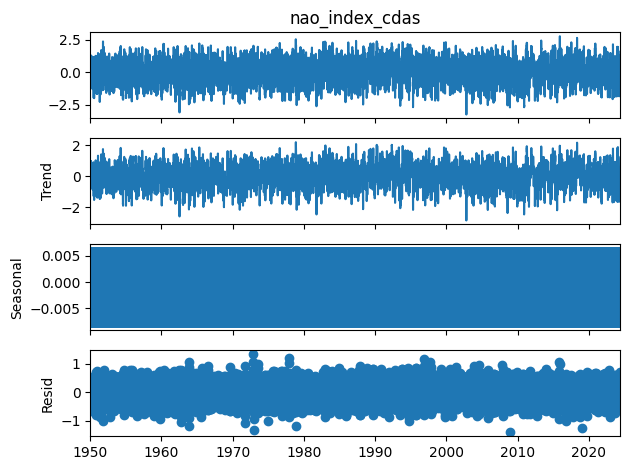

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_multiplicative = seasonal_decompose(NAO_df["nao_index_cdas"], model = "additive")
s_dec_multiplicative.plot()
plt.show()

In [22]:
annual_mean = NAO_df.resample('Y').mean().rename(columns={'nao_index_cdas': 'annual_mean'})

# Create a new DataFrame to interpolate the annual mean to match the length of the x-axis
interpolated_annual_mean = annual_mean.reindex(
    pd.date_range(start=annual_mean.index[0], end=NAO_df.index[-1], freq='D')
).interpolate(method='linear')


/var/folders/sw/v81yw5q1605g978yjjbbqgjr0000gn/T/ipykernel_4021/3124310937.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean = NAO_df.resample('Y').mean().rename(columns={'nao_index_cdas': 'annual_mean'})


/var/folders/sw/v81yw5q1605g978yjjbbqgjr0000gn/T/ipykernel_4021/1702778123.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range(start='1950', end='2025', freq='Y').year


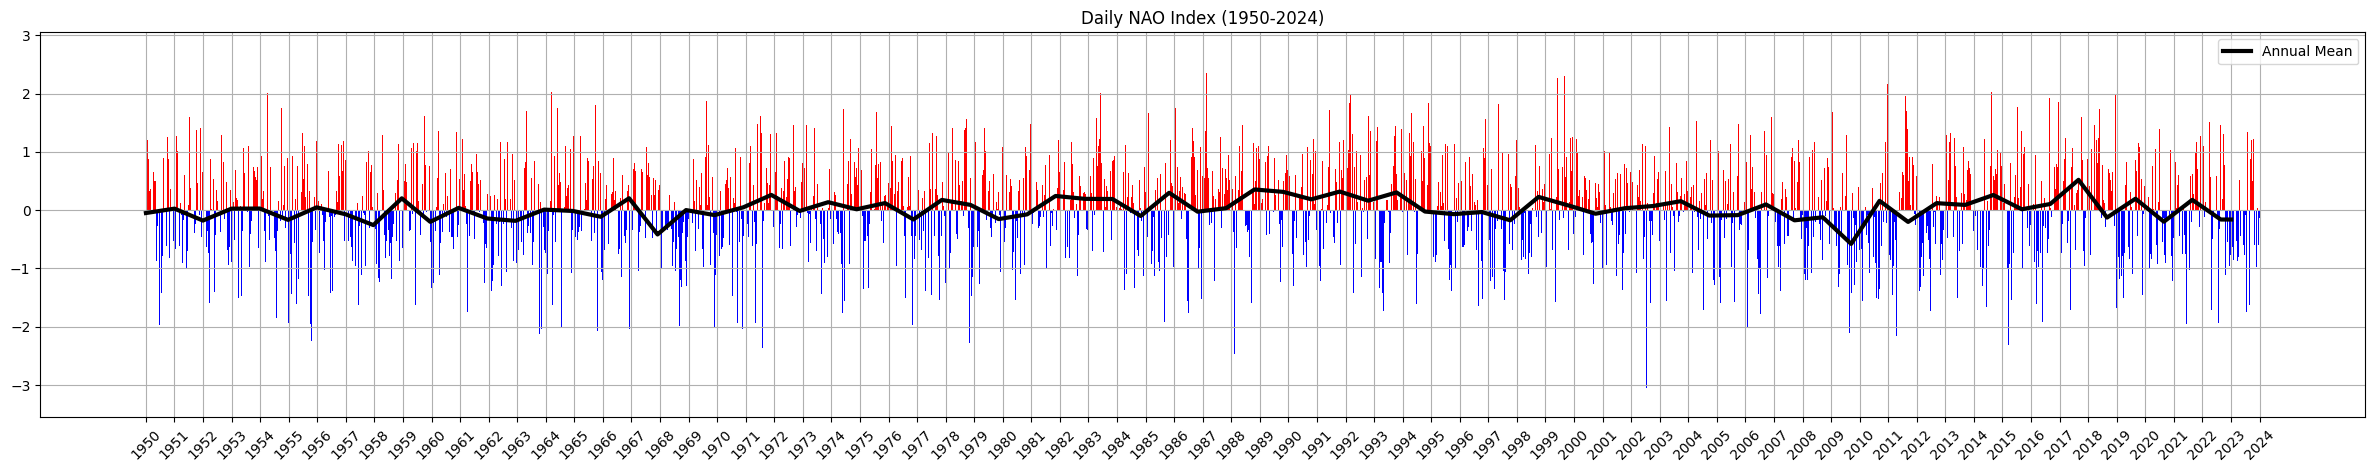

In [23]:
plt.figure(figsize=[30,5])
colors = ['red' if value > 0 else 'blue' for value in NAO_df["nao_index_cdas"]]
plt.bar(np.arange(len(NAO_df)), NAO_df["nao_index_cdas"], color=colors)
plt.plot(np.arange(len(interpolated_annual_mean)), interpolated_annual_mean['annual_mean'], color="k", linewidth=3, label="Annual Mean")
years = pd.date_range(start='1950', end='2025', freq='Y').year
plt.xticks(ticks=np.linspace(0, len(NAO_df)-1, len(years)), labels=years, rotation=45)
plt.legend()
plt.grid()
plt.title("Daily NAO Index (1950-2024)")
plt.show()

## Model

In [24]:
#Splitting Data for training and test data

total_length = len(NAO_df)
train_length = int(total_length * 0.6)
validation_length = int(total_length * 0.2)

# Split data into training, validation, and test sets
train_df = NAO_df.iloc[:train_length]
validation_df = NAO_df.iloc[train_length:train_length + validation_length]
test_df = NAO_df.iloc[train_length + validation_length:]

# Print shapes of each dataset
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {validation_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (16298, 1)
Validation data shape: (5432, 1)
Testing data shape: (5434, 1)


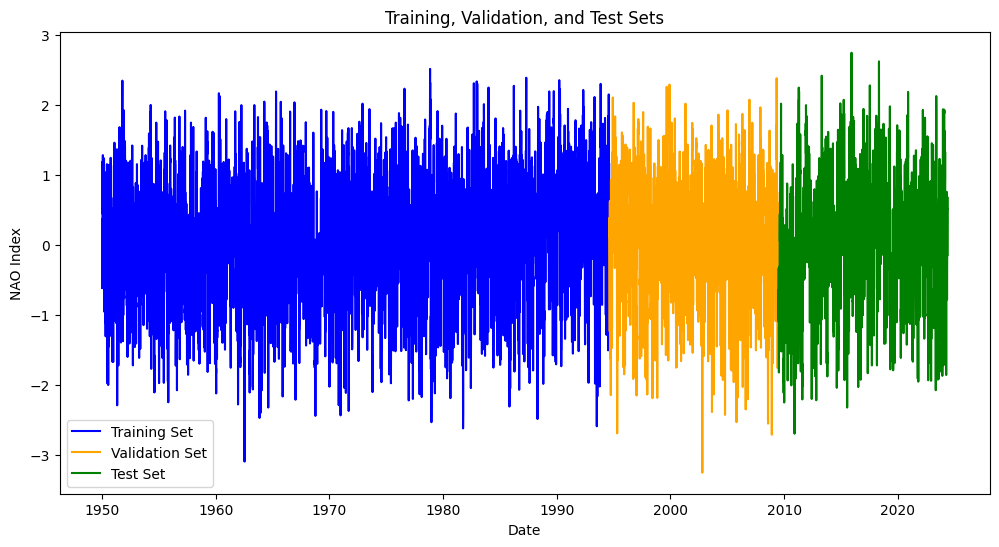

In [25]:
plt.figure(figsize=(12, 6)) 
plt.plot(train_df.index, train_df["nao_index_cdas"], color='blue', label='Training Set')
plt.plot(validation_df.index, validation_df["nao_index_cdas"], color='orange', label='Validation Set')
plt.plot(test_df.index, test_df["nao_index_cdas"], color='green', label='Test Set')

plt.xlabel('Date')
plt.ylabel('NAO Index')
plt.title('Training, Validation, and Test Sets')
plt.legend()
plt.show()

In [26]:
# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_df['nao_index_cdas'].values.reshape(-1, 1)).reshape(-1)
validation_scaled = scaler.transform(validation_df['nao_index_cdas'].values.reshape(-1, 1)).reshape(-1)
test_scaled = scaler.transform(test_df['nao_index_cdas'].values.reshape(-1, 1)).reshape(-1)

In [27]:
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data) - input_length):
        x = data[i:(i + input_length)]
        y = data[i + input_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
# using 24 days to predict 1 day
input_length = 24

X_train, y_train = create_sequences(train_scaled, input_length)
X_validation, y_validation = create_sequences(validation_scaled, input_length)
X_test, y_test = create_sequences(test_scaled, input_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_validation = X_validation.reshape((X_validation.shape[0], X_validation.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shapes: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation data shapes: X_validation {X_validation.shape}, y_validation {y_validation.shape}")
print(f"Testing data shapes: X_test {X_test.shape}, y_test {y_test.shape}")

Training data shapes: X_train (16274, 24, 1), y_train (16274,)
Validation data shapes: X_validation (5408, 24, 1), y_validation (5408,)
Testing data shapes: X_test (5410, 24, 1), y_test (5410,)


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NBeatsNet(stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  forecast_length=5,
                  backcast_length=input_length,
                  hidden_layer_units=64,
                  nb_blocks_per_stack=3,
                  device=device)

model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=24, forecast_length=5, share_thetas=False) at @11304835248
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=24, forecast_length=5, share_thetas=False) at @6308870608
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=24, forecast_length=5, share_thetas=False) at @11304835920
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=24, forecast_length=5, share_thetas=False) at @11274505184
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=24, forecast_length=5, share_thetas=False) at @11274504512
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=24, forecast_length=5, share_thetas=False) at @11304786144


In [29]:
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().unsqueeze(-1).to(device)

X_validation_tensor = torch.tensor(X_validation).float().to(device)
y_validation_tensor = torch.tensor(y_validation).float().unsqueeze(-1).to(device)

X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().unsqueeze(-1).to(device)

In [30]:
num_epochs = 50

# Initialize lists to store training and validation losses
train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred_train = model(X_train_tensor)[0]  # Assuming the first element is the prediction tensor
    # Compute loss
    loss_train = criterion(y_pred_train, y_train_tensor)
    # Backward pass
    loss_train.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        # Forward pass
        y_pred_validation = model(X_validation_tensor)[0]  # Assuming the first element is the prediction tensor
        # Compute loss
        loss_validation = criterion(y_pred_validation, y_validation_tensor)
    
    # Record training and validation losses
    train_losses.append(loss_train.item())
    validation_losses.append(loss_validation.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_validation.item():.4f}')
    
    # Early stopping logic (example)
    # Adjust this part based on your early stopping criteria
    if epoch > 0 and validation_losses[-1] > validation_losses[-2]:
        print(f'Validation loss stopped improving, stopping early at epoch {epoch+1}')
        break



/Users/tanja/Documents/OpenCampus/NAO_Prediction/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16274, 1])) that is different to the input size (torch.Size([16274, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tanja/Documents/OpenCampus/NAO_Prediction/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5408, 1])) that is different to the input size (torch.Size([5408, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Train Loss: 0.3083, Validation Loss: 0.2906
Epoch [20/50], Train Loss: 0.1633, Validation Loss: 0.1594
Epoch [30/50], Train Loss: 0.1135, Validation Loss: 0.1133
Epoch [40/50], Train Loss: 0.0952, Validation Loss: 0.0959
Epoch [50/50], Train Loss: 0.0794, Validation Loss: 0.0807


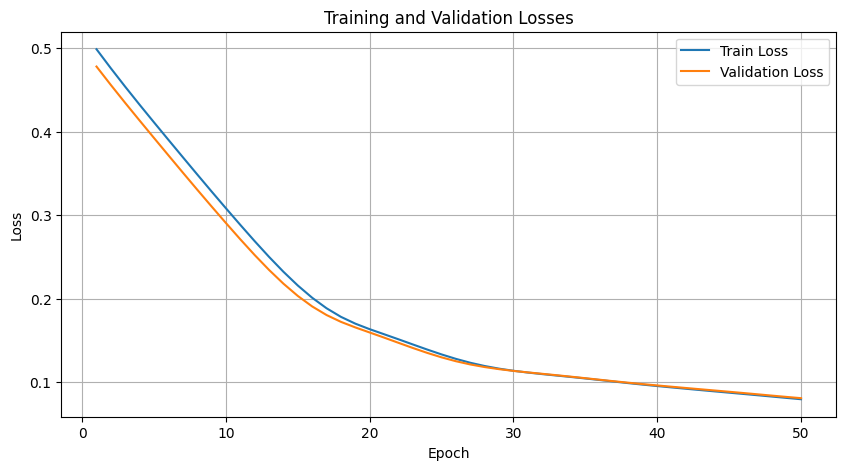

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(np.arange(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
validation_df.index

DatetimeIndex(['1994-08-16', '1994-08-17', '1994-08-18', '1994-08-19',
               '1994-08-20', '1994-08-21', '1994-08-22', '1994-08-23',
               '1994-08-24', '1994-08-25',
               ...
               '2009-06-20', '2009-06-21', '2009-06-22', '2009-06-23',
               '2009-06-24', '2009-06-25', '2009-06-26', '2009-06-27',
               '2009-06-28', '2009-06-29'],
              dtype='datetime64[ns]', name='date', length=5432, freq=None)

In [33]:
def predict_with_model(model, X_tensor):
    model.eval()
    with torch.no_grad():
        model_output = model(X_tensor)
        if isinstance(model_output, tuple):
            y_pred = model_output[0] 
        else:
            y_pred = model_output  

        y_pred = y_pred.cpu().detach().numpy()[:, -1] 
    return y_pred


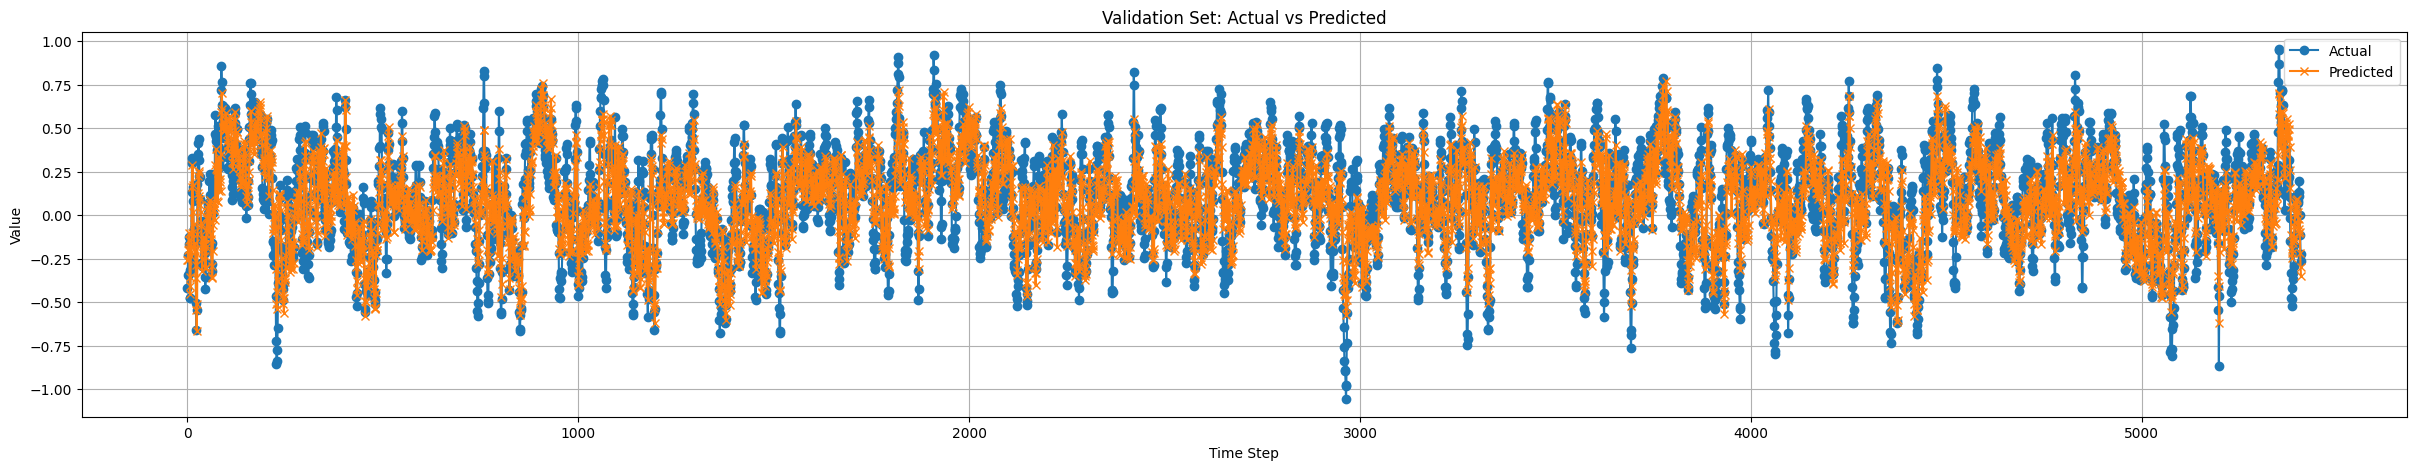

In [34]:
y_pred_validation = predict_with_model(model, X_validation_tensor)
# Plot actual vs predicted values
plt.figure(figsize=(30, 5))
plt.plot(y_validation, label='Actual', marker='o')
plt.plot(y_pred_validation, label='Predicted', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Validation Set: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

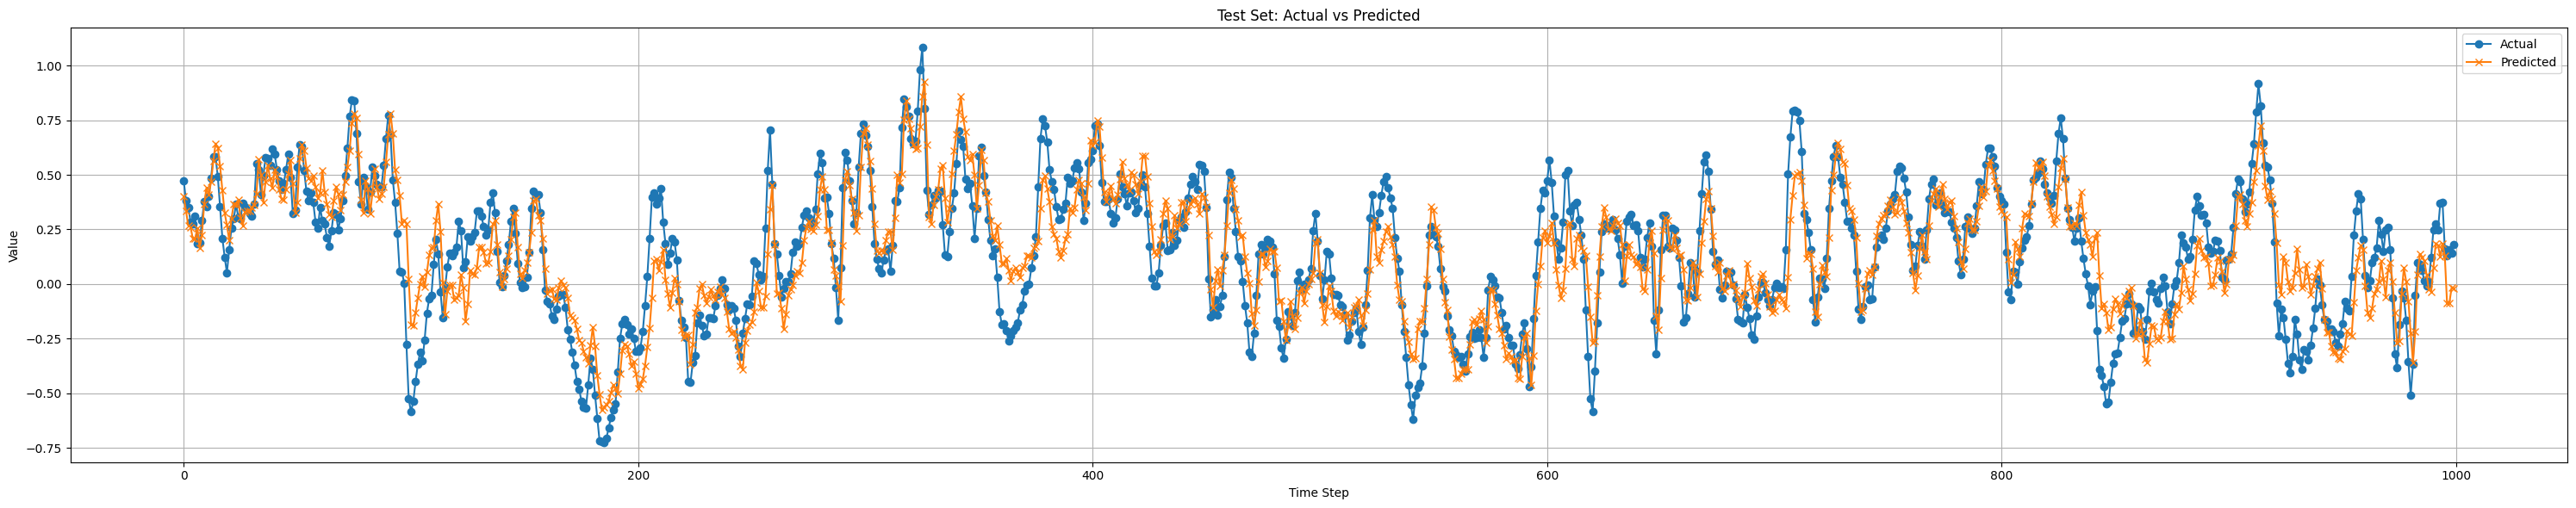

In [35]:
y_pred_test = predict_with_model(model, X_test_tensor)

# Plot actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test[2000:3000], label='Actual', marker='o')
plt.plot(y_pred_test[2000:3000], label='Predicted', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:

print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred_test: {y_pred_test.shape}")

Shape of y_test: (5410,)
Shape of y_pred_test: (5410,)


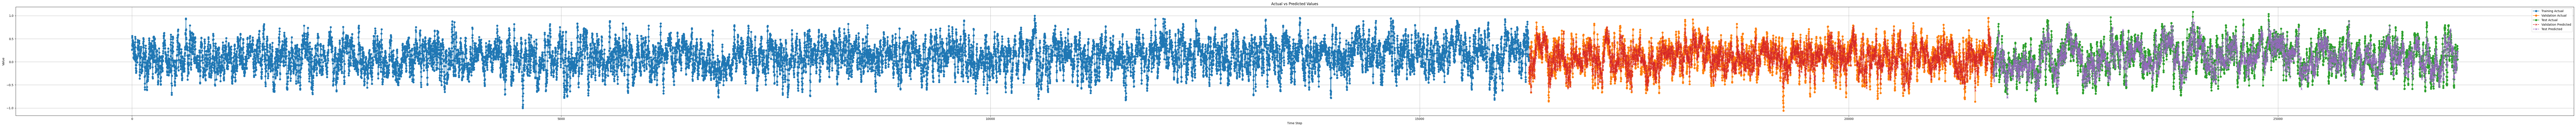

In [37]:

# Plotting
plt.figure(figsize=(120, 6))

# Plotting actual values
plt.plot(np.arange(len(y_train)), y_train, label='Training Actual', marker='o', linestyle='-')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_validation)), y_validation, label='Validation Actual', marker='o', linestyle='-')
plt.plot(np.arange(len(y_train) + len(y_validation), len(y_train) + len(y_validation) + len(y_test)), y_test, label='Test Actual', marker='o', linestyle='-')

# Plotting predicted values for validation set
plt.plot(np.arange(len(y_train), len(y_train) + len(y_validation)), y_pred_validation, label='Validation Predicted', marker='x', linestyle='--')

# Plotting predicted values for test set
plt.plot(np.arange(len(y_train) + len(y_validation), len(y_train) + len(y_validation) + len(y_test)), y_pred_test, label='Test Predicted', marker='x', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
def phase_check(y_test,y_pred):
  """
  Args:
    y_test
    y_pred
  Returns: phase agreement of the two time series in percentage
  """
  y_test_phases = np.zeros(len(y_test))
  y_pred_phases = np.zeros(len(y_pred))
  negative_test = np.where(y_test <-1)[0]
  negative_pred = np.where(y_pred <-1)[0]
  positive_test = np.where(y_test >1)[0]
  positive_pred = np.where(y_pred >1)[0]
  y_test_phases[negative_test] = -1
  y_pred_phases[negative_pred] = -1
  y_test_phases[positive_test] = 1
  y_pred_phases[positive_pred] = 1
  counter = np.sum(y_test_phases==y_pred_phases)
  phase_percent = 100/len(y_test) * counter
  return phase_percent

In [39]:
phase_percent = phase_check(y_test, y_pred_test)
phase_percent

np.float64(99.96303142329022)

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

mae_validation = mean_absolute_error(y_validation, y_pred_validation)
mae_test = mean_absolute_error(y_test, y_pred_test)

mse_validation = mean_squared_error(y_validation, y_pred_validation)
mse_test = mean_squared_error(y_test, y_pred_test)

# Calculate RMSE
rmse_validation = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Calculate R-squared
r2_validation = r2_score(y_validation, y_pred_validation)
r2_test = r2_score(y_test, y_pred_test)

# Calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Calculate Median Absolute Error
medae_validation = median_absolute_error(y_validation, y_pred_validation)
medae_test = median_absolute_error(y_test, y_pred_test)

# Print results
print(f"Metrics for Validation Set:")
print(f"Mean absolute error: {mae_validation:.4f}")
print(f"Mean squared error: {mse_validation:.4f}")
print(f"Median Absolute Error: {medae_validation:.4f}")
print()
print(f"Metrics for Test Set:")
print(f"Mean absolute error: {mae_test:.4f}")
print(f"Mean squared error: {mse_test:.4f}")
#print(f"Median Absolute Error: {medae_test:.4f}")
print(f"Phase Percent: {phase_percent:.4f}")

Metrics for Validation Set:
Mean absolute error: 0.1210
Mean squared error: 0.0228
Median Absolute Error: 0.1026

Metrics for Test Set:
Mean absolute error: 0.1230
Mean squared error: 0.0234
Phase Percent: 99.9630
